# **Chargement des packages nécessaires**

In [44]:
import pandas as pd
import numpy as np
import re
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import FileLink
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import AutoModel, TrainingArguments, Trainer, pipeline, AutoTokenizer, BertModel, get_scheduler, BertTokenizer
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from torch.optim import AdamW
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# **Chargement des données et suppression des données manquantes**

In [45]:
data =  pd.read_csv("/content/Corona_NLP_train.csv",encoding="latin1")

# Exploration des données

In [46]:
# Dimension du jeu de données
data.shape

(41157, 6)

C'est un jeu de données de 41157 observations et 6 variables

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


- Nous avons deux variables de type integer UserName et ScreenName; les autres sont de type objet
- Seule la variable *Location* présente des données manquantes.
- Nous sommes intéressés essentiellement par deux variables. Nous allons donc les sélectionner et voir s'il y a des doublons

In [48]:
# Sélection des variables d'intérêt
data = data[['OriginalTweet', 'Sentiment']]

In [49]:
# Nous allons checker pour voir s'il y a des doublons

data_duplicate = data[data.duplicated(subset=['OriginalTweet', 'Sentiment'], keep=False)]
data_duplicate.shape

(0, 2)

On note qu'il n'y a pas de données doublons.

In [50]:
data = data[['OriginalTweet', 'Sentiment']].dropna()

Statistiques descriptives de la variable Sentiment

In [51]:
# Afficher les classes de sentiments
print(data['Sentiment'].value_counts())

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


Encodage des étiquettes de Sentiment. Nous voulons définir l'encodage nous même de sorte à avoir :
    'Extremely Positive' =4
    'Positive'= 3,
    'Neutral'= 2,
    'Negative'= 1,
    'Extremely Negative'=0


In [52]:


label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['Sentiment'])

label_mapping = {
    'Extremely Positive':4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative':0

}
data['label']=data.Sentiment.map(label_mapping)


<Axes: ylabel='Sentiment'>

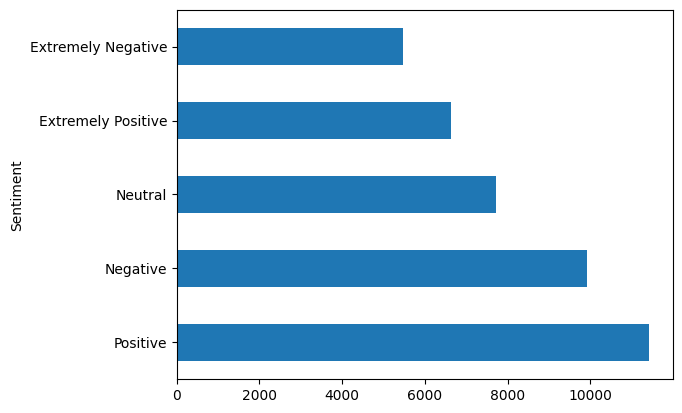

In [53]:
# Représentation
data.Sentiment.value_counts().plot(kind='barh')

Nettoyage du dataset en supprimant les etimocones, les symboles, les espaces vides, etc

In [54]:
def convert_to_lower(text):
    return text.lower()


def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    return wierd_pattern.sub(r'', text)

def remove_punctuation(text):
            # Remove punctuation and carriage return/newline characters
  cleaned_text = re.sub(r'[^\w\s]+|[\r\n]', '', text)
  return cleaned_text


def remove_extra_white_spaces(text):
    clean_text=text.strip()
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=clean_text)
    return without_sc


def preprocessText(text):
  return remove_extra_white_spaces(remove_punctuation(remove_emojis(convert_to_lower(text))))



data['OriginalTweet'] = data['OriginalTweet'].apply(preprocessText)
data['OriginalTweet'] = data['OriginalTweet'].apply(preprocessText)



Définition de la classe

In [55]:


tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

Définition des données d'entrainement et de test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data['OriginalTweet'], data['label'], test_size=0.2, random_state=42)

train_dataset = CustomDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

Définition du model BERT à utiliser pour la classification

In [57]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:

training_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for epoch in range(3):  # nombre d'époques
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        avg_loss_epoch = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")
    # Sauvegarde du modèle pour une éventuelle utilisation
    model_save_path = f"model.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Modèle sauvegardé dans : {model_save_path}")

    # Sauvegarder l'optimiseur
    optimizer_save_path = f"optimizer.pt"
    torch.save(optimizer.state_dict(), optimizer_save_path)
    print(f"Optimiseur sauvegardé dans : {optimizer_save_path}")

print("\nEntraînement terminé.")


100%|██████████| 2058/2058 [11:57<00:00,  2.87it/s]


Epoch 1, Loss: 1713.4374
Modèle sauvegardé dans : model.pt
Optimiseur sauvegardé dans : optimizer.pt


100%|██████████| 2058/2058 [12:04<00:00,  2.84it/s]


Epoch 2, Loss: 970.0051
Modèle sauvegardé dans : model.pt
Optimiseur sauvegardé dans : optimizer.pt


100%|██████████| 2058/2058 [12:04<00:00,  2.84it/s]


Epoch 3, Loss: 681.3322
Modèle sauvegardé dans : model.pt
Optimiseur sauvegardé dans : optimizer.pt

Entraînement terminé.


Sauvegarde des informations sur la qualité du modèle

In [59]:
model.eval()
val_loss = 0
preds = []
true = []



with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true.extend(labels.cpu().numpy())

print(classification_report(true, preds, target_names=label_encoder.classes_))




                    precision    recall  f1-score   support

Extremely Negative       0.78      0.90      0.83      1056
Extremely Positive       0.76      0.79      0.77      2006
          Negative       0.92      0.81      0.86      1553
           Neutral       0.84      0.76      0.80      2287
          Positive       0.83      0.90      0.86      1330

          accuracy                           0.82      8232
         macro avg       0.82      0.83      0.83      8232
      weighted avg       0.82      0.82      0.82      8232



In [ ]:
pip install fpdf

Enregistrement du rapport de classification en pdf

In [61]:
from fpdf import FPDF

report_text = classification_report(true, preds, target_names=label_encoder.classes_)

# Affiche dans la console
print(report_text)

# Enregistrement dans un PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

# Pour découper le texte ligne par ligne
for line in report_text.split('\n'):
    pdf.cell(200, 10, txt=line.strip(), ln=True)

# Enregistrement final
pdf.output("classification_report.pdf")
print("✅ Rapport enregistré dans 'classification_report.pdf'")

                    precision    recall  f1-score   support

Extremely Negative       0.78      0.90      0.83      1056
Extremely Positive       0.76      0.79      0.77      2006
          Negative       0.92      0.81      0.86      1553
           Neutral       0.84      0.76      0.80      2287
          Positive       0.83      0.90      0.86      1330

          accuracy                           0.82      8232
         macro avg       0.82      0.83      0.83      8232
      weighted avg       0.82      0.82      0.82      8232

✅ Rapport enregistré dans 'classification_report.pdf'
